In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import poisson, nbinom, kurtosis, skew
import seaborn as sns

In [39]:
# Load the claims data file into a DataFrame 
file_path = "C:\\Users\\thoma\\OneDrive\\Desktop\\Cours HEC Autumn 2024\\Assurances\\Assessment Underwritting\\claim_data_group4_2024.csv"
claims_data = pd.read_csv(file_path)
claims_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [40]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2.617735e+06,0.039020,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887
std,1.643394e+06,0.206296,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302
min,1.500000e+01,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000
25%,1.156127e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000
50%,2.271008e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000
75%,4.044791e+06,0.000000,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000
max,6.114324e+06,4.000000,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000


In [45]:
# Get the distribution of individual claims
claims_distribution = claims_data['ClaimNb'].value_counts()
claims_distribution

ClaimNb
0    96335
1     3441
2      214
3        7
4        3
Name: count, dtype: int64

In [43]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('DrivAge')['ClaimNb'].sum()
total_claims_by_age = pd.DataFrame(total_claims_by_age)
total_claims_by_age

,ClaimNb
DrivAge,
18,6
19,30
20,55
21,42
22,58
...,...
94,0
95,1
96,0


In [50]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('VehAge')['ClaimNb'].sum()
total_claims_by_vech_age = pd.DataFrame(total_claims_by_age)
print(total_claims_by_vech_age.head)

<bound method NDFrame.head of         ClaimNb
VehAge         
0           167
1           326
2           335
3           288
4           267
5           227
6           219
7           240
8           227
9           254
10          248
11          208
12          187
13          154
14          161
15          136
16           83
17           73
18           38
19           19
20           16
21            8
22            8
23            4
24            2
25            0
26            3
27            0
28            2
29            1
30            1
31            0
32            0
33            0
34            0
35            0
36            0
37            0
38            0
39            0
40            0
41            0
43            0
44            0
45            0
46            0
47            0
50            0
52            0
65            0
66            0
68            0
99            0
100           0>


In [44]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus = claims_data.groupby('BonusMalus')['ClaimNb'].sum()
total_claims_by_bonus_malus = pd.DataFrame(total_claims_by_bonus_malus)
total_claims_by_bonus_malus

,ClaimNb
BonusMalus,
50,1694
51,59
52,28
53,18
54,63
...,...
190,0
195,0
196,0


In [51]:
# Total claims by driver's age 
total_claims_by_age = claims_data.groupby('VehPower')['ClaimNb'].sum()
total_claims_by_vech_power = pd.DataFrame(total_claims_by_age)
total_claims_by_vech_power

,ClaimNb
VehPower,
4,529
5,764
6,929
7,849
8,257
9,194
10,157
11,112
12,57


C:\Users\thoma\AppData\Local\Temp\ipykernel_16228\1330275754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ClaimNb', data=claims_data, palette='Set2')


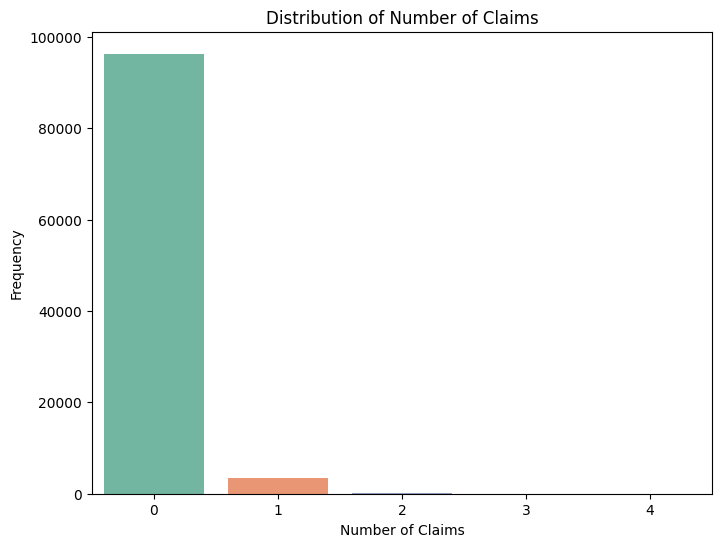

In [46]:
# Plotting the distribution of ClaimNb
plt.figure(figsize=(8, 6))
sns.countplot(x='ClaimNb', data=claims_data, palette='Set2')
plt.title('Distribution of Number of Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.show()

In [47]:
skewness = skew(claims_data['ClaimNb'])
kurt = kurtosis(claims_data['ClaimNb'])
skewness, kurt

(np.float64(5.729207125692899), np.float64(37.72487026616426))